# RecSys Project - Casino Recommendations - EDA

## Imports

In [144]:
import pickle
from typing import Set, List, Optional

import numpy as np
import pandas as pd
import pdpipe as pdp
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

In [2]:
pd.options.display.float_format = '${:,.2f}'.format

## Data Loading

In [3]:
from recasino.data import (
    Col,
    set_data_dpath,
    get_raw_dataframe,
)

In [141]:
class Col:
    DATE = 'dt_date_ID'
    USER = 'CID'
    COUNTRY = 'Country_ID'
    GAME = 'GameType_ID'
    VENDOR = 'VendorID'
    BETS = 'Bets'
    WEEK = 'week'
    RATING = 'rating'

In [4]:
data_dpath = '/Users/shaypalachy/data/mba/recsys/project/'

In [5]:
set_data_dpath(data_dpath)

In [164]:
rdf = get_raw_dataframe()

In [165]:
rdf.head(3)

,dt_date_ID,CID,Country_ID,GameType_ID,VendorID,Bets
0,2020-05-01,798441298,84,504,27,$0.89
1,2020-05-01,799100355,37,2138,54,$0.66
2,2020-05-01,834556973,234,2244,71,$2.12


In [166]:
rdf.shape

(3401368, 6)

In [167]:
FIRST_DAY = rdf[Col.DATE].values[0]
FIRST_DAY

numpy.datetime64('2020-05-01T00:00:00.000000000')

In [168]:
WEEKS = list(range(1, 10))
WEEKS

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [226]:
rdf[Col.USER].nunique()

226384

In [227]:
226384 * 9

2037456

## Dates and duration

In [169]:
len(rdf[Col.DATE].unique())

63

In [170]:
len(rdf[Col.DATE].unique()) / 7

9.0

In [171]:
DAYS = sorted(rdf[Col.DATE].unique())

In [172]:
def days_by_week(week: int) -> List[str]:
    i = (week - 1) * 7
    return DAYS[i:i+7]

In [173]:
days_by_week(9)

[numpy.datetime64('2020-06-26T00:00:00.000000000'),
 numpy.datetime64('2020-06-27T00:00:00.000000000'),
 numpy.datetime64('2020-06-28T00:00:00.000000000'),
 numpy.datetime64('2020-06-29T00:00:00.000000000'),
 numpy.datetime64('2020-06-30T00:00:00.000000000'),
 numpy.datetime64('2020-07-01T00:00:00.000000000'),
 numpy.datetime64('2020-07-02T00:00:00.000000000')]

In [174]:
def subdf_by_week(df: pd.DataFrame, week: int) -> pd.DataFrame:
    return df[df[Col.DATE].isin(days_by_week(week))]

In [175]:
sdf = pd.concat([rdf.iloc[0:100], rdf.iloc[900000:900100]])

In [176]:
sdf

,dt_date_ID,CID,Country_ID,GameType_ID,VendorID,Bets
0,2020-05-01,798441298,84,504,27,$0.89
1,2020-05-01,799100355,37,2138,54,$0.66
2,2020-05-01,834556973,234,2244,71,$2.12
3,2020-05-01,825738816,234,2162,47,$5.51
4,2020-05-01,808929419,234,938,32,$7.96
...,...,...,...,...,...,...
900095,2020-05-16,802793752,54,1744,1,$0.68
900096,2020-05-16,821297948,84,593,1,$0.12
900097,2020-05-16,816818400,37,1370,47,$12.81
900098,2020-05-16,792475443,234,483,1,$0.25


In [177]:
day_to_week = {}
for week in WEEKS:
    days = days_by_week(week)
    for day in days:
        day_to_week[day] = week

In [178]:
# day_to_week

In [179]:
sdf[Col.DATE].map(day_to_week)

0         1
1         1
2         1
3         1
4         1
         ..
900095    3
900096    3
900097    3
900098    3
900099    3
Name: dt_date_ID, Length: 200, dtype: int64

### Add the week column

In [180]:
rdf[Col.WEEK] = rdf[Col.DATE].map(day_to_week)

In [181]:
rdf

,dt_date_ID,CID,Country_ID,GameType_ID,VendorID,Bets,week
0,2020-05-01,798441298,84,504,27,$0.89,1
1,2020-05-01,799100355,37,2138,54,$0.66,1
2,2020-05-01,834556973,234,2244,71,$2.12,1
3,2020-05-01,825738816,234,2162,47,$5.51,1
4,2020-05-01,808929419,234,938,32,$7.96,1
...,...,...,...,...,...,...,...
3401363,2020-07-02,754754251,234,2480,48,$7.16,9
3401364,2020-07-02,772112357,234,1172,28,$7.05,9
3401365,2020-07-02,766621428,73,1773,1,$5.71,9
3401366,2020-07-02,814027660,84,2373,82,$58.38,9


## Bets

In [182]:
rdf[Col.BETS].describe()

count   $3,401,368.00
mean           $95.31
std         $1,002.74
min             $0.00
25%             $3.50
50%            $12.16
75%            $42.90
max       $784,943.48
Name: Bets, dtype: float64

In [183]:
sum(rdf[Col.BETS] < 0.1)

66016

### Daily per-user, per-game bets distributions

<AxesSubplot:>

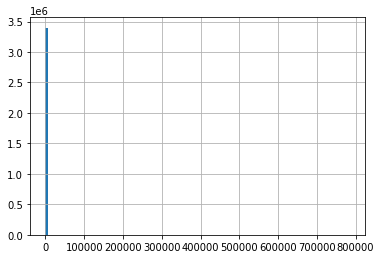

In [184]:
rdf[Col.BETS].hist(bins=100)

<AxesSubplot:>

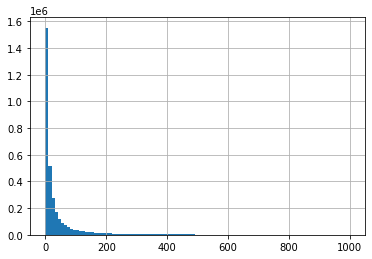

In [185]:
rdf[Col.BETS].hist(bins=100, range=(0,1000))

<AxesSubplot:>

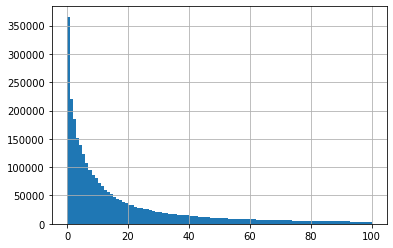

In [186]:
rdf[Col.BETS].hist(bins=100, range=(0,100))

### Overall per-user, per-game bets distributions

<AxesSubplot:>

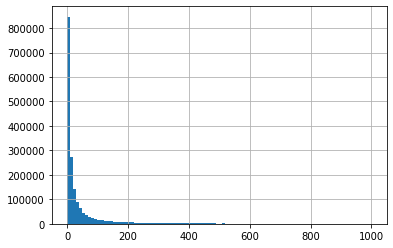

In [187]:
rdf.groupby([Col.USER, Col.GAME]).sum()[Col.BETS].hist(bins=100, range=(0,1000))

<AxesSubplot:>

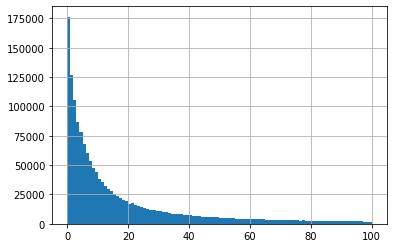

In [188]:
rdf.groupby([Col.USER, Col.GAME]).sum()[Col.BETS].hist(bins=100, range=(0,100))

## Top games over time

In [189]:
rdf[rdf[Col.DATE].isin(days_by_week(1))].groupby(Col.GAME).sum(
    )[Col.BETS].sort_values(ascending=False)[0:10]

GameType_ID
2196   $1,485,755.22
954    $1,007,816.68
512      $993,121.89
1673     $801,898.54
508      $783,562.06
1307     $762,403.67
2120     $564,812.30
593      $546,287.99
483      $529,845.62
1033     $516,614.15
Name: Bets, dtype: float64

In [190]:
def top_n_games_by_week(df: pd.DataFrame, week: int, n: Optional[int] = 10) -> pd.Series:
    gb = subdf_by_week(df, week).groupby(Col.GAME)
    return gb.sum()[Col.BETS].sort_values(ascending=False)[0:n]

In [191]:
top_n_games_by_week(rdf, 1)

GameType_ID
2196   $1,485,755.22
954    $1,007,816.68
512      $993,121.89
1673     $801,898.54
508      $783,562.06
1307     $762,403.67
2120     $564,812.30
593      $546,287.99
483      $529,845.62
1033     $516,614.15
Name: Bets, dtype: float64

In [192]:
top_n_games_by_week(rdf, 2)

GameType_ID
2196   $1,412,061.72
954      $949,952.21
512      $695,997.46
1307     $621,676.81
1673     $611,606.30
483      $518,127.98
1033     $463,786.27
2020     $450,438.75
1714     $419,437.36
1144     $417,278.88
Name: Bets, dtype: float64

In [193]:
def top_n_games_over_entire_period(df: pd.DataFrame, n: Optional[int] = 10) -> pd.Series:
    top_games = []
    for w in WEEKS:
        top_games.extend(top_n_games_by_week(df=df, week=w, n=n))
    return set(top_games)

In [194]:
top_10_join = top_n_games_over_entire_period(rdf)

In [195]:
len(top_10_join)

90

## Introduced games

In [35]:
game_intro_dates = rdf.groupby(Col.GAME).min()[Col.DATE]

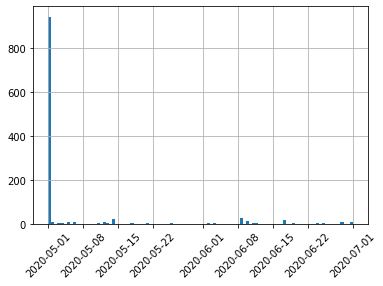

In [36]:
game_intro_dates.hist(bins=100)
plt.xticks(rotation=45);

In [37]:
game_intro_dates[game_intro_dates > FIRST_DAY]

GameType_ID
506    2020-06-09
626    2020-05-02
701    2020-06-05
747    2020-05-02
901    2020-06-11
          ...    
2509   2020-06-17
2512   2020-06-25
2513   2020-07-01
2514   2020-07-01
2518   2020-06-25
Name: dt_date_ID, Length: 181, dtype: datetime64[ns]

In [38]:
len(game_intro_dates[game_intro_dates > FIRST_DAY]) / len(game_intro_dates)

0.1608888888888889

## Top daily games per user over time

In [40]:
FIRST_USER = rdf[Col.USER].iloc[0]
FIRST_USER

798441298

In [42]:
udf = rdf[rdf[Col.USER] == FIRST_USER]
udf.head(3)

,dt_date_ID,CID,Country_ID,GameType_ID,VendorID,Bets
0,2020-05-01,798441298,84,504,27,$0.89
24688,2020-05-01,798441298,84,1773,1,$0.08
38686,2020-05-01,798441298,84,1878,40,$96.70


In [47]:
udf.groupby(Col.GAME).sum()[Col.BETS].sort_values(ascending=False)[0:3]

GameType_ID
1878   $338.03
884    $196.00
1772    $57.55
Name: Bets, dtype: float64

In [88]:
def all_top_n_weekly_games_by_user(df: pd.DataFrame, user: int, n: Optional[int] = 3) -> Set[int]:
    top_games = []
    for week in WEEKS:
        sdf = subdf_by_week(df, week)
        udf = sdf[sdf[Col.USER] == user]
        top_games.extend(
            udf.groupby(Col.GAME).sum().sort_values(Col.BETS, ascending=False).index[0:n])
    return set(top_games)

In [89]:
# udf.groupby(Col.GAME).sum().sort_values(Col.BETS, ascending=False)

In [90]:
all_top_n_weekly_games_by_user(rdf, FIRST_USER)

{504, 884, 1113, 1317, 1772, 1878, 2011}

In [91]:
def unique_top_n_weekly_games_per_user_dist(
    df: pd.DataFrame,
    n: Optional[int] = 3,
    users: Optional[List[int]] = None,
) -> List[int]:
    counts = []
    if users is None:
        users = list(df[Col.USER].unique())
    for user in tqdm(users):
        counts.append(len(all_top_n_weekly_games_by_user(df, user, n)))
    return counts

In [92]:
len(rdf[Col.USER].unique())

226384

In [93]:
rdf[Col.USER].sample(10).values

array([812278019, 825698049,   2528545, 811784376, 804667177, 825173854,
       811881859, 808797388, 829113170, 820907835])

In [94]:
top3_per_user_counts = unique_top_n_weekly_games_per_user_dist(rdf, 3, users=rdf[Col.USER].sample(1000))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [95]:
fpath = 'top3_per_user_counts.pkl'
with open(fpath, 'wb+') as f:
    pickle.dump(top3_per_user_counts, f)

<AxesSubplot:ylabel='Count'>

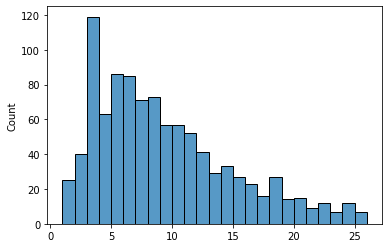

In [100]:
sns.histplot(top3_per_user_counts, bins=25)

## Choosing the rating scale

In [127]:
weekly_per_user_n_game_bets = rdf.groupby([Col.USER, Col.GAME, Col.WEEK]).sum()[Col.BETS]

<AxesSubplot:>

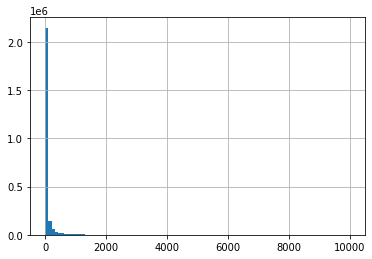

In [131]:
weekly_per_user_n_game_bets.hist(bins=100, range=(0,10000))

<AxesSubplot:>

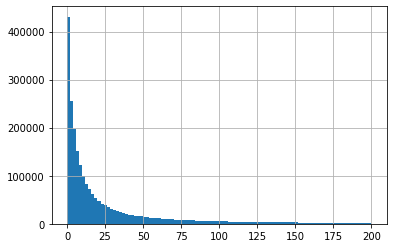

In [132]:
weekly_per_user_n_game_bets.hist(bins=100, range=(0,200))

<AxesSubplot:>

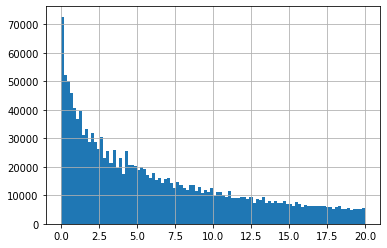

In [133]:
weekly_per_user_n_game_bets.hist(bins=100, range=(0,20))

## Bets to rating

### Naive attempt

In [209]:
np.percentile(weekly_per_user_n_game_bets, 90)

162.6905

In [210]:
np.percentile(weekly_per_user_n_game_bets, 95)

373.2436749999993

In [137]:
np.percentile(weekly_per_user_n_game_bets, 50)

11.935

In [138]:
np.percentile(weekly_per_user_n_game_bets, 10)

0.945

In [139]:
np.percentile(weekly_per_user_n_game_bets, 30)

4.62

In [140]:
np.percentile(weekly_per_user_n_game_bets, 70)

32.445

In [146]:
class BetsRatingConverter:
    
    def __init__(self, cap1: float, cap2: float, cap3: float, cap4: float) -> None:
        self.cap1 = cap1
        self.cap2 = cap2
        self.cap3 = cap3
        self.cap4 = cap4 
        
    def __call__(self, bets_value: float) -> int:
        if bets_value < self.cap1:
            return 1
        if bets_value < self.cap2:
            return 2
        if bets_value < self.cap3:
            return 3
        if bets_value < self.cap4:
            return 4
        return 5

In [153]:
bets2ratings = pdp.MapColVals(
    columns=Col.BETS,
    value_map=BetsRatingConverter(1, 5, 32, 160),
    result_columns=Col.RATING,
    drop=False,
)

In [155]:
post_df = bets2ratings(rdf)
post_df

,dt_date_ID,CID,Country_ID,GameType_ID,VendorID,Bets,rating,week
0,2020-05-01,798441298,84,504,27,$0.89,1,1
1,2020-05-01,799100355,37,2138,54,$0.66,1,1
2,2020-05-01,834556973,234,2244,71,$2.12,2,1
3,2020-05-01,825738816,234,2162,47,$5.51,3,1
4,2020-05-01,808929419,234,938,32,$7.96,3,1
...,...,...,...,...,...,...,...,...
3401363,2020-07-02,754754251,234,2480,48,$7.16,3,9
3401364,2020-07-02,772112357,234,1172,28,$7.05,3,9
3401365,2020-07-02,766621428,73,1773,1,$5.71,3,9
3401366,2020-07-02,814027660,84,2373,82,$58.38,4,9


In [ ]:
post_df[Col.RATING].hist()

### Per-user scale

In [219]:
# subdf = rdf[[Col.USER, Col.WEEK, Col.GAME, Col.BETS]].iloc[0:400000]

In [266]:
# 400000 / len(rdf)

0.11759974222136504

In [220]:
# subdf

,CID,week,GameType_ID,Bets
0,798441298,1,504,$0.89
1,799100355,1,2138,$0.66
2,834556973,1,2244,$2.12
3,825738816,1,2162,$5.51
4,808929419,1,938,$7.96
...,...,...,...,...
399995,836581350,1,1774,$0.49
399996,811331697,1,1095,$86.01
399997,833798045,1,2035,$3.37
399998,825169915,1,512,$6.24


In [267]:
uwg_gb = rdf.groupby([Col.USER, Col.WEEK, Col.GAME])

In [268]:
weekly_per_user_and_game_bets = uwg_gb.sum()
weekly_per_user_and_game_bets

Country_ID  VendorID       Bets
CID       week GameType_ID                                 
35485     1    611                 798         7 $18,492.08
          2    611                 684         6 $12,140.98
          4    611                 342         3  $6,537.30
          5    611                 798         7 $13,700.31
          6    611                 570         5  $6,064.10
...                                ...       ...        ...
838502307 5    1035                234        21      $8.99
          7    1035                468        42     $46.11
838502409 1    438                 234         1      $2.33
               483                 234         1      $2.13
               954                 234        35      $2.76

[2506620 rows x 3 columns]

In [269]:
weekly_per_user_bets = weekly_per_user_and_game_bets.groupby([Col.USER, Col.WEEK]).sum()
weekly_per_user_bets

Country_ID  VendorID       Bets
CID       week                                 
35485     1            798         7 $18,492.08
          2            684         6 $12,140.98
          4            342         3  $6,537.30
          5            798         7 $13,700.31
          6            570         5  $6,064.10
...                    ...       ...        ...
838502174 1            168        81     $23.59
838502307 4            234        21      $8.80
          5            234        21      $8.99
          7            468        42     $46.11
838502409 1            702        37      $7.22

[470809 rows x 3 columns]

Per-user ratings relative to weekly spend:

```python
5: (v >= 0.30 weekly spend AND v > 10$) OR (v > 1000$)

4: (v >= 0.20 weekly spend AND v >  7$) OR (v >  500$)

3: (v >= 0.15 weekly spend AND v >  5$) OR (v >  300$)

2: (v >= 0.10 weekly spend AND v >  1$) OR (v >  100$)

1: else
```

In [270]:
PORTIONS = np.array([0.3, 0.2, 0.15, 0.1])

In [271]:
PORTIONS_LBLS = ['portion0.3', 'portion0.2', 'portion0.15', 'portion0.1']

In [272]:
def _bets_to_portions(row):
    return pd.Series(
        data=row[Col.BETS] * PORTIONS,
        index=PORTIONS_LBLS,
    )

In [273]:
add_per_user_weekly_bets_portions = pdp.ApplyToRows(_bets_to_portions)

In [274]:
weekly_per_user_bets = add_per_user_weekly_bets_portions(weekly_per_user_bets)

In [275]:
weekly_per_user_bets

Country_ID  VendorID       Bets  portion0.1  portion0.15  \
CID       week                                                             
35485     1            798         7 $18,492.08   $1,849.21    $2,773.81   
          2            684         6 $12,140.98   $1,214.10    $1,821.15   
          4            342         3  $6,537.30     $653.73      $980.60   
          5            798         7 $13,700.31   $1,370.03    $2,055.05   
          6            570         5  $6,064.10     $606.41      $909.62   
...                    ...       ...        ...         ...          ...   
838502174 1            168        81     $23.59       $2.36        $3.54   
838502307 4            234        21      $8.80       $0.88        $1.32   
          5            234        21      $8.99       $0.90        $1.35   
          7            468        42     $46.11       $4.61        $6.92   
838502409 1            702        37      $7.22       $0.72        $1.08   

                portion0.2  portion0.3  
CID       week                          
35485     1      $3,698.42   $5,547.62  
          2      $2,428.20   $3,642.29  
          4      $1,307.46   $1,961.19  
          5      $2,740.06   $4,110.09  
          6      $1,212.82   $1,819.23  
...                    ...         ...  
838502174 1          $4.72       $7.08  
838502307 4          $1.76       $2.64  
          5          $1.80       $2.70  
          7          $9.22      $13.83  
838502409 1          $1.44       $2.17  

[470809 rows x 7 columns]

In [276]:
weekly_per_user_bets.index[0]

(35485, 1)

In [277]:
weekly_per_user_bets.loc[(35485, 1)]

Country_ID       $798.00
VendorID           $7.00
Bets          $18,492.08
portion0.1     $1,849.21
portion0.15    $2,773.81
portion0.2     $3,698.42
portion0.3     $5,547.62
Name: (35485, 1), dtype: float64

In [278]:
weekly_per_user_and_game_bets

Country_ID  VendorID       Bets
CID       week GameType_ID                                 
35485     1    611                 798         7 $18,492.08
          2    611                 684         6 $12,140.98
          4    611                 342         3  $6,537.30
          5    611                 798         7 $13,700.31
          6    611                 570         5  $6,064.10
...                                ...       ...        ...
838502307 5    1035                234        21      $8.99
          7    1035                468        42     $46.11
838502409 1    438                 234         1      $2.33
               483                 234         1      $2.13
               954                 234        35      $2.76

[2506620 rows x 3 columns]

Per-user ratings relative to weekly spend:

```python
5: (v >= weekly_stats['portion0.3'] AND v > 10) OR (v > 1000)

4: (v >= weekly_stats['portion0.2'] AND v >  7) OR (v >  500)

3: (v >= weekly_stats['portion0.15'] AND v >  5) OR (v >  300)

2: (v >= weekly_stats['portion0.1'] AND v >  1) OR (v >  100)

1: else
```

In [279]:
def _get_rating_from_row(row: pd.Series) -> int:
    v = row[Col.BETS]
    user, week, game = row.name
    weekly_stats = weekly_per_user_bets.loc[(user, week)]
    if (v >= weekly_stats['portion0.3']  and v > 10) or (v > 1000):
        return 5
    if (v >= weekly_stats['portion0.2']  and v > 7 ) or (v >  500):
        return 4
    if (v >= weekly_stats['portion0.15'] and v >  5) or (v >  300):
        return 3
    if (v >= weekly_stats['portion0.1']  and v >  1) or (v >  100):
        return 2
    return 1

In [280]:
bet2rating = pdp.ApplyToRows(
    func=_get_rating_from_row,
    colname=Col.RATING,
)

In [281]:
weekly_per_user_and_game_bets = bet2rating(weekly_per_user_and_game_bets, verbose=True)

- Generating a column with a function .


In [282]:
weekly_per_user_and_game_bets

Country_ID  VendorID       Bets  rating
CID       week GameType_ID                                         
35485     1    611                 798         7 $18,492.08       5
          2    611                 684         6 $12,140.98       5
          4    611                 342         3  $6,537.30       5
          5    611                 798         7 $13,700.31       5
          6    611                 570         5  $6,064.10       5
...                                ...       ...        ...     ...
838502307 5    1035                234        21      $8.99       4
          7    1035                468        42     $46.11       5
838502409 1    438                 234         1      $2.33       2
               483                 234         1      $2.13       2
               954                 234        35      $2.76       2

[2506620 rows x 4 columns]

<AxesSubplot:>

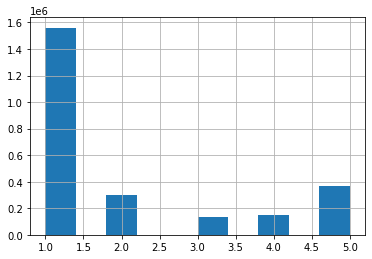

In [283]:
weekly_per_user_and_game_bets[Col.RATING].hist()

In [285]:
import pickle

In [284]:
with open('weekly_per_user_and_game_bets.pkl', 'wb+') as f:
    pickle.dump(weekly_per_user_and_game_bets, f)

In [286]:
weekly_per_user_and_game_bets

Country_ID  VendorID       Bets  rating
CID       week GameType_ID                                         
35485     1    611                 798         7 $18,492.08       5
          2    611                 684         6 $12,140.98       5
          4    611                 342         3  $6,537.30       5
          5    611                 798         7 $13,700.31       5
          6    611                 570         5  $6,064.10       5
...                                ...       ...        ...     ...
838502307 5    1035                234        21      $8.99       4
          7    1035                468        42     $46.11       5
838502409 1    438                 234         1      $2.33       2
               483                 234         1      $2.13       2
               954                 234        35      $2.76       2

[2506620 rows x 4 columns]